In [4]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [2]:
import torch

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device
print("Device:", device)

Device: cuda


# 1 Preparation and Dataset Understanding

## 1.1 Answer-Sentence Natural Questions (ASNQ) Dataset for the transfer step of TANDA
ASNQ is a accurate, general and large AS2 corpus used to validate the benefits of TANDA and derived from the Google Natural Questions (NQ) dataset (Kwiatkowski et al. 2019). In NQ dataset, each question is related to a Wikipedia page, a long paragraph(long_answer)  containing the answer, and each long_answer may contain phrases annotated as short_answers.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

In [ ]:
dataset = load_dataset("asnq")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/20377568 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/930062 [00:00<?, ? examples/s]

In ASNQ dataset, for each question, the positive candidate answers are those sentences that occur in the long_answer paragraphs in NQ and contain annotated short answers. And the negative answers contain three types of sentences:

(1). In the long answer but do not contain the annotated short answers.\
(2). Not in the long answer but contain the short answer string.\
(3). Neither in the long answer nor contain the short answer.

The negative answers are important to the robustness of the model in identifying the best answer among the similar but incorrect ones.

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 20377568
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 930062
    })
})


- Sample Data Exploration

In [ ]:
dataset["train"].select(range(5)).to_pandas()

,question,sentence,label,sentence_in_long_answer,short_answer_in_sentence
0,what is the use of fn key in mac,It is typically found on laptops due to their ...,0,False,False
1,when did the ipod 7th generation come out,"Cupertino , California : Apple .",0,False,False
2,who dies in season 6 once upon a time,"^ Jump up to : Abrams , Natalie ( August 5 , 2...",0,False,False
3,who was the first avatar ever in the last airb...,Jeremy Zuckerman and Benjamin Wynn composed th...,0,False,False
4,how many games do they need to win to win the ...,p. 21 .,0,False,False


In [ ]:
# Since pandas is more efficient for data prepocessing
df_train = dataset["train"].to_pandas()

# Print the length of questions and answers
df_train['question_length'] = df_train['question'].apply(lambda x: len(x.split()))
df_train['answer_length'] = df_train['sentence'].apply(lambda x: len(x.split()))

# Using describe for Basic statistics
print(df_train[['question_length', 'answer_length']].describe())

# Distribution of question types (Who, What, Where, etc.)
df_train['question_type'] = df_train['question'].apply(lambda x: x.split()[0])
print(df_train['question_type'].value_counts())

       question_length  answer_length
count     2.037757e+07   2.037757e+07
mean      9.130250e+00   2.229073e+01
std       1.676836e+00   5.720475e+01
min       4.000000e+00   1.000000e+00
25%       8.000000e+00   8.000000e+00
50%       9.000000e+00   1.500000e+01
75%       1.000000e+01   2.600000e+01
max       2.100000e+01   2.283900e+04
who        5504958
when       5401938
what       2870313
where      2399202
how        1353214
            ...   
dale            12
ep-13           12
mmts            11
organic         10
fort            10
Name: question_type, Length: 1947, dtype: int64


In [ ]:
print(df_train.isnull().sum())

question                    0
sentence                    0
label                       0
sentence_in_long_answer     0
short_answer_in_sentence    0
question_length             0
answer_length               0
question_type               0
dtype: int64


In [ ]:
if 'label' in df_train.columns:
    print(df_train['label'].value_counts())

0    20316382
1       61186
Name: label, dtype: int64


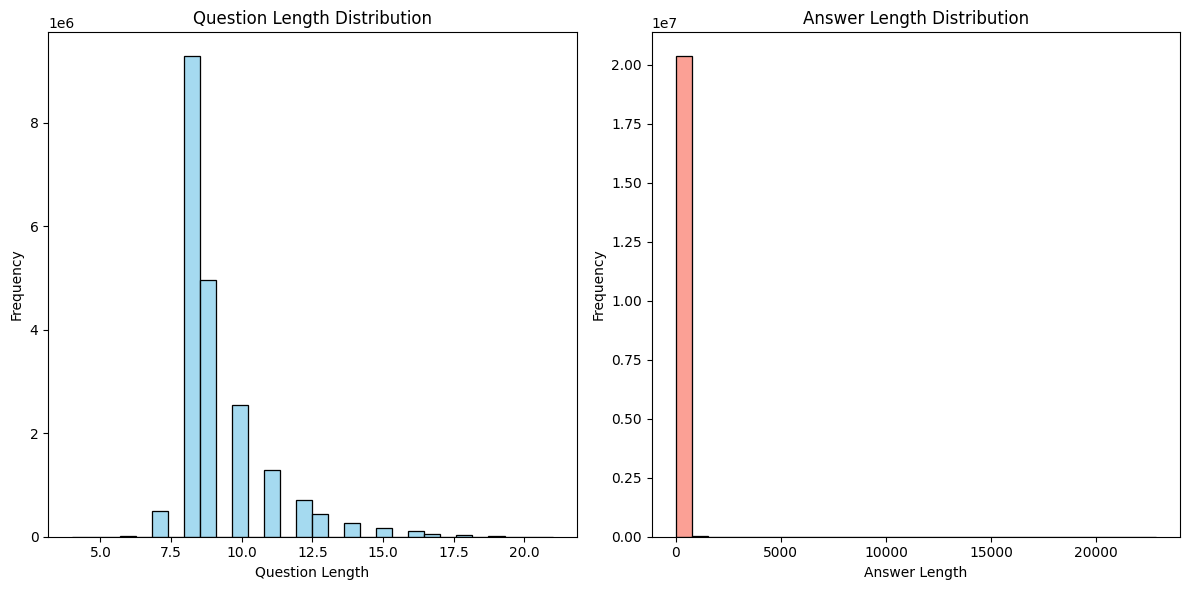

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


# Question length distribution
sns.histplot(df_train['question_length'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Question Length')
axes[0].set_ylabel('Frequency')

# Answer length distribution
sns.histplot(df_train['answer_length'], bins=30, ax=axes[1], color='salmon')
axes[1].set_title('Answer Length Distribution')
axes[1].set_xlabel('Answer Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1.2 Choosing Wiki QA Dataset for the adaption step of TANDA
WikiQA rely on Wikipedia might offer a broader range of topics.


In [ ]:
dataset = load_dataset("wiki_qa")

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 20360
    })
})


In [ ]:
dataset["train"].select(range(5)).to_pandas()

,question_id,question,document_title,answer,label
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0


In [ ]:
train_df = pd.DataFrame(dataset["train"])

train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()))
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(x.split()))

print(train_df[['question_length', 'answer_length']].describe())

print(train_df['label'].value_counts(normalize=True))

       question_length  answer_length
count     20360.000000   20360.000000
mean          6.885658      22.729028
std           2.436096      11.535818
min           2.000000       1.000000
25%           5.000000      15.000000
50%           6.000000      21.000000
75%           8.000000      29.000000
max          21.000000     166.000000
0    0.948919
1    0.051081
Name: label, dtype: float64


In [ ]:
# Missing values
print(train_df.isnull().sum())

# Duplicates
print(f"Duplicates: {train_df.duplicated().sum()}")

question_id        0
question           0
document_title     0
answer             0
label              0
question_length    0
answer_length      0
dtype: int64
Duplicates: 2


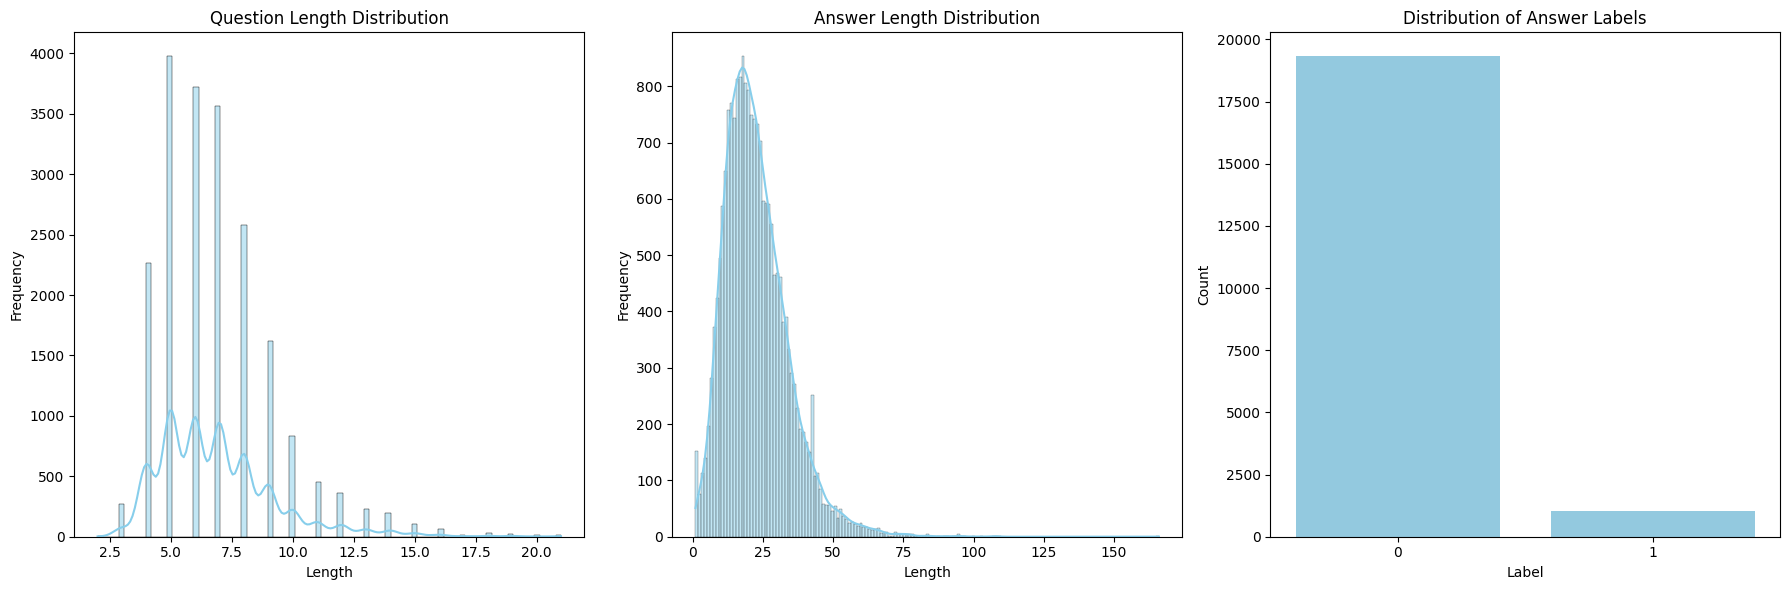

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(train_df['question_length'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Question Length Distribution')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Frequency')

sns.histplot(train_df['answer_length'], kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('Answer Length Distribution')
axes[1].set_xlabel('Length')
axes[1].set_ylabel('Frequency')

sns.countplot(x='label', data=train_df, ax=axes[2], color='skyblue')
axes[2].set_title('Distribution of Answer Labels')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# 2 Model Implementation

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## 2.1 Baseline Transformer Model Testing on Wiki QA dataset
In this task I will use transfor to preprocessing the data including tokenization, padding, and truncation. italicized text.

For question-answering models of BERT models, the input is then represented like this: `[CLS] Sequence A [SEP] Sequence B [SEP]`, which take a context and a question

In [7]:
dataset_wiki_qa = load_dataset("wiki_qa")
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [8]:
def tokenize_function_wiki_qa(examples):
    return tokenizer(examples['question'], examples['answer'], truncation=True, padding='max_length', max_length=128, add_special_tokens=True, return_tensors="pt")

tokenized_wiki_qa_datasets = dataset_wiki_qa.map(tokenize_function_wiki_qa, batched=True)

Map:   0%|          | 0/6165 [00:00<?, ? examples/s]

Map:   0%|          | 0/2733 [00:00<?, ? examples/s]

Map:   0%|          | 0/20360 [00:00<?, ? examples/s]

Check the encode result and use tokenizer.decode to validate if the special tokens have been properly added

In [9]:
print('Questions: ',tokenized_wiki_qa_datasets["train"][0]['question'])
print('Answer: ',tokenized_wiki_qa_datasets["train"][0]['answer'])
print('Input IDs: ',tokenized_wiki_qa_datasets["train"][0]['input_ids'])
print('Token Type IDs: ',tokenized_wiki_qa_datasets["train"][0]['token_type_ids'])
print('Attention Mask: ',tokenized_wiki_qa_datasets["train"][0]['attention_mask'])
print('Decode results: ',tokenizer.decode(tokenized_wiki_qa_datasets["train"][0]["input_ids"]))

Questions:  how are glacier caves formed?
Answer:  A partly submerged glacier cave on Perito Moreno Glacier .
Input IDs:  [101, 1293, 1132, 19121, 12142, 1824, 136, 102, 138, 6146, 14203, 19121, 5812, 1113, 14286, 8383, 19388, 13972, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs:  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask:  [1, 1, 1, 1, 

In [10]:
print(tokenized_wiki_qa_datasets)
tokenized_wiki_qa_datasets_after = tokenized_wiki_qa_datasets.remove_columns(['question_id', 'question', 'document_title', 'answer'])
tokenized_wiki_qa_datasets_after = tokenized_wiki_qa_datasets_after.rename_column('label','labels')
tokenized_wiki_qa_datasets_after.set_format('torch')
print("After removing the unuseful columns:")
print(tokenized_wiki_qa_datasets_after)

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20360
    })
})
After removing the unuseful columns:
DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num

In [30]:
tokenized_train_wikiqa_dataset = tokenized_wiki_qa_datasets_after['train'].shuffle(seed=42)#.select(range(5000))
tokenized_validation_wikiqa_dataset = tokenized_wiki_qa_datasets_after['validation'].shuffle(seed=42)#.select(range(2000))
tokenized_test_wikiqa_dataset = tokenized_wiki_qa_datasets_after['test'].shuffle(seed=42)#.select(range(1000))

### Fine-tuning in PyTorch with the Trainer API

In [33]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
import evaluate

base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="base_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize Trainer
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_train_wikiqa_dataset,
    eval_dataset=tokenized_validation_wikiqa_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.179400,0.155982,0.949872,0.941206,0.949872,0.944274
2,0.109300,0.187161,0.954995,0.947207,0.954995,0.949240
3,0.065700,0.231098,0.949872,0.944395,0.949872,0.946682


TrainOutput(global_step=3819, training_loss=0.11794062202655385, metrics={'train_runtime': 523.6748, 'train_samples_per_second': 116.637, 'train_steps_per_second': 7.293, 'total_flos': 4017705815347200.0, 'train_loss': 0.11794062202655385, 'epoch': 3.0})

In [34]:
test_results = trainer.evaluate(tokenized_test_wikiqa_dataset)
print("Test Evaluation Results:", test_results)

Test Evaluation Results: {'eval_loss': 0.14157655835151672, 'eval_accuracy': 0.9544201135442011, 'eval_precision': 0.9444462830496804, 'eval_recall': 0.9544201135442011, 'eval_f1': 0.9472047710668405, 'eval_runtime': 14.2146, 'eval_samples_per_second': 433.709, 'eval_steps_per_second': 27.155, 'epoch': 3.0}


In [35]:
from datasets import concatenate_datasets

positive_examples = tokenized_test_wikiqa_dataset.filter(lambda example: example['labels'] == 1)
negative_examples = tokenized_test_wikiqa_dataset.filter(lambda example: example['labels'] == 0)

# Determine the minimum size
min_size = min(len(positive_examples), len(negative_examples))

# Randomly sample examples from each group
positive_subset = positive_examples.shuffle(seed=42).select(range(min_size))
negative_subset = negative_examples.shuffle(seed=42).select(range(min_size))

# Combine and shuffle the samples to create a balanced dataset
balanced_subset = concatenate_datasets([positive_subset, negative_subset]).shuffle(seed=42)

In [36]:
test_results = trainer.evaluate(balanced_subset)
print("Test Evaluation Results:", test_results)

Test Evaluation Results: {'eval_loss': 1.1616528034210205, 'eval_accuracy': 0.6313993174061433, 'eval_precision': 0.7701980885769719, 'eval_recall': 0.6313993174061433, 'eval_f1': 0.5770875654870096, 'eval_runtime': 1.6208, 'eval_samples_per_second': 361.561, 'eval_steps_per_second': 22.829, 'epoch': 3.0}


In [32]:
del base_model
del trainer
torch.cuda.empty_cache()

### Fine-tuning in native PyTorch

In [ ]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(small_validation_dataset, batch_size=32)

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AdamW

model_name = 'bert-base-cased'
baseline_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(baseline_model.parameters(), lr=5e-5)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
from tqdm.auto import tqdm

baseline_model.train()
train_loss = 0
for batch in tqdm(train_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = baseline_model(**batch)
    loss = outputs.loss
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

print(f"Average training loss: {train_loss / len(train_dataloader)}")

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader

model.eval()
eval_loss = 0
with torch.no_grad():
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()

print(f"Validation loss: {eval_loss / len(eval_dataloader)}")

## 2.2 TANDA fine-tunning Transformer Model with ASNQ and Wiki QA dataset
In this task I will use transfor to preprocessing the data including tokenization, padding, and truncation.

In [37]:
# Load the ASNQ dataset
dataset_asnq = load_dataset("asnq")
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Generating train split:   0%|          | 0/20377568 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/930062 [00:00<?, ? examples/s]

In [62]:
print(dataset_asnq)
small_train_asnq_dataset = dataset_asnq['train'].shuffle(seed=42).select(range(10000))
small_validation_asnq_dataset = dataset_asnq['validation'].shuffle(seed=42).select(range(3000))

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 20377568
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 930062
    })
})


In [63]:
# Tokenize the input (question, sentence) pairs
def tokenize_function(examples):
    return tokenizer(examples["question"], examples["sentence"], padding="max_length", truncation=True, max_length=128, add_special_tokens=True, return_tensors="pt")

tokenized_train_asnq_dataset = small_train_asnq_dataset.map(tokenize_function, batched=True)
tokenized_validation_asnq_dataset = small_validation_asnq_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [64]:
print('Questions: ',tokenized_train_asnq_dataset[0]['question'])
print('Answer: ',tokenized_train_asnq_dataset[0]['sentence'])
print('label: ',tokenized_train_asnq_dataset[0]['label'])
print('Input IDs: ',tokenized_train_asnq_dataset[0]['input_ids'])
print('Token Type IDs: ',tokenized_train_asnq_dataset[0]['token_type_ids'])
print('Attention Mask: ',tokenized_train_asnq_dataset[0]['attention_mask'])
print('Decode results: ',tokenizer.decode(tokenized_train_asnq_dataset[0]["input_ids"]))

Questions:  when do new episodes of fairy tail come out
Answer:  Retrieved July 30 , 2015 .
label:  0
Input IDs:  [101, 1165, 1202, 1207, 3426, 1104, 11210, 5287, 1435, 1149, 102, 4996, 1351, 1476, 117, 1410, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token Type IDs:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [65]:
tokenized_train_asnq_after = tokenized_train_asnq_dataset.remove_columns(['question', 'sentence', 'sentence_in_long_answer', 'short_answer_in_sentence'])
tokenized_train_asnq_after = tokenized_train_asnq_after.rename_column('label','labels')
tokenized_train_asnq_after.set_format('torch')
print("tokenized_train_asnq_dataset After removing the unuseful columns:")
print(tokenized_train_asnq_after)

tokenized_validation_asnq_after = tokenized_validation_asnq_dataset.remove_columns(['question', 'sentence', 'sentence_in_long_answer', 'short_answer_in_sentence'])
tokenized_validation_asnq_after = tokenized_validation_asnq_after.rename_column('label','labels')
tokenized_validation_asnq_after.set_format('torch')
print("tokenized_validation_asnq_after After removing the unuseful columns:")
print(tokenized_validation_asnq_after)

tokenized_train_asnq_dataset After removing the unuseful columns:
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})
tokenized_validation_asnq_after After removing the unuseful columns:
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


### Hyperparameter Tuning

1. different learning rate {2e−4,2e−5,2e−6}

In [66]:
del transfered_TANDA_model
del transfer_trainer
torch.cuda.empty_cache()

In [67]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
import evaluate

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
transfered_TANDA_model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    output_dir="transfer_TANDA_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)

    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initialize Trainer
transfer_trainer = Trainer(
    model=transfered_TANDA_model,
    args=training_args,
    train_dataset=tokenized_train_asnq_after,
    eval_dataset=tokenized_validation_asnq_after,
    compute_metrics=compute_metrics,
)

# Train the model
transfer_trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.031200,0.028590,0.995667,0.991352,0.995667,0.993505
2,0.016900,0.032811,0.995667,0.991352,0.995667,0.993505
3,0.006500,0.041426,0.992333,0.992618,0.992333,0.992475


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1875, training_loss=0.01502724396387736, metrics={'train_runtime': 276.6236, 'train_samples_per_second': 108.451, 'train_steps_per_second': 6.778, 'total_flos': 1973332915200000.0, 'train_loss': 0.01502724396387736, 'epoch': 3.0})

In [68]:
# Initialize Trainer
adapt_trainer = Trainer(
    model=transfer_trainer.model,
    args=training_args,
    train_dataset=tokenized_train_wikiqa_dataset,
    eval_dataset=tokenized_validation_wikiqa_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
adapt_trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.177000,0.153120,0.951336,0.941708,0.951336,0.944563
2,0.100800,0.195248,0.953897,0.946298,0.953897,0.948626
3,0.057300,0.238937,0.952799,0.947180,0.952799,0.949373


Checkpoint destination directory transfer_TANDA_model/checkpoint-1273 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory transfer_TANDA_model/checkpoint-2546 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory transfer_TANDA_model/checkpoint-3819 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=3819, training_loss=0.1103150734073612, metrics={'train_runtime': 510.546, 'train_samples_per_second': 119.637, 'train_steps_per_second': 7.48, 'total_flos': 4017705815347200.0, 'train_loss': 0.1103150734073612, 'epoch': 3.0})

In [70]:
test_results = adapt_trainer.evaluate(tokenized_test_wikiqa_dataset)
print("Test Evaluation Results:", test_results)
test_results = adapt_trainer.evaluate(balanced_subset)
print("Test Evaluation Results:", test_results)

Test Evaluation Results: {'eval_loss': 0.13979241251945496, 'eval_accuracy': 0.9547445255474453, 'eval_precision': 0.9446940557332925, 'eval_recall': 0.9547445255474453, 'eval_f1': 0.9473128362546126, 'eval_runtime': 15.622, 'eval_samples_per_second': 394.637, 'eval_steps_per_second': 24.709, 'epoch': 3.0}
Test Evaluation Results: {'eval_loss': 1.1579923629760742, 'eval_accuracy': 0.6313993174061433, 'eval_precision': 0.7757731328688424, 'eval_recall': 0.6313993174061433, 'eval_f1': 0.5758916006594025, 'eval_runtime': 1.5827, 'eval_samples_per_second': 370.242, 'eval_steps_per_second': 23.377, 'epoch': 3.0}
